# Transformer Model
'Attention is all you need'이라는 논문에서 소개된 Transformer model은 논문의 제목에 걸맞게 CNN과 RNN을 사용하지 않고 attention을 이용하여 기계번역을 수행합니다. 이 모델의 입력 문장의 형식은 seq-to-seq모델처럼 각 입력 문장의 시작과 끝에 < sos >, < eos >가 있으며, 모델의 구조는 encoder-decoder형식입니다. 인코더의 output이 디코더에 입력되고, 디코더는 디코더에 입력된 값과 인코더에서 받은 값으로 연산을 수행해 output을 만들어냅니다. 그 이후, linear layer에 그 output을 통과시킨 후 softmax를 취해 확률분포를 리턴하는 구조입니다. 아래의 과정은 Multi30k데이터를 학습시키는 과정이며, 각 파트별로 논문에서 설명하는 곳과 비교하며 제가 이해한 바를 보이겠습니다.

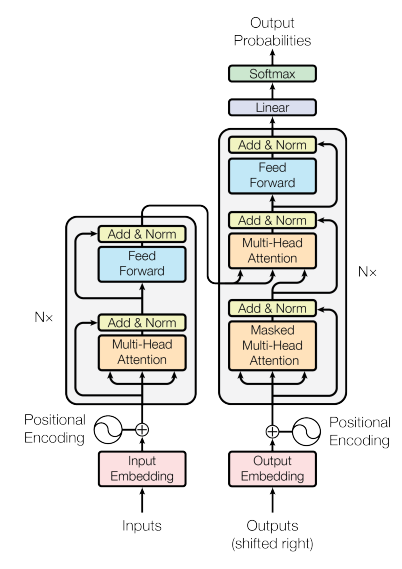

# 버전 맞추기

In [1]:
!pip install torchtext==0.10.01 #버전이 이와 동일해야 에러가 나지 않음

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 20.3 MB/s 
     |████████████████████████████████| 831.4 MB 7.1 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.1 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.1 which is incompatible.


# 데이터 로딩

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
###################################
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
###################################
!python3 -m spacy download de_core_news_sm
!python3 -m spacy download en_core_web_sm
import en_core_web_sm, de_core_news_sm
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')
###################################
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]
#########################################
SRC = Field(tokenize = tokenize_de, 
            init_token = '', 
            eos_token = '', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '', 
            eos_token = '', 
            lower = True, 
            batch_first = True)
#########################################
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))
#########################################
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)
#########################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#########################################
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 26.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 608 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:03<00:00, 360kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 111kB/s] 


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 106kB/s]


# 인코더와 디코더의 공통된 입력 방식

"I am a student"를 "나는 학생이다"로 번역할 때, "I am a student"를 source sentence라고, "나는 학생이다"는 target sentence라고 부릅니다. 이때, 학습 과정에서 source sentence는 encoder에, target sentence는 decoder에 입력됩니다.

Encoder와 Decoder모두 문장을 입력받으면 텍스트 데이터를 컴퓨터가 다룰 수 있게 word embedding을 수행하는데, 이 방식은 seq to seq 모델과 똑같이 진행됩니다.

임베딩층을 통과한 후 position Encoding을 수행합니다. 이를 수행하는 이유는, 앞서 말한 바와 같이 transformer 모델은 CNN과 RNN을 수행하지 않기 때문에 단어의 sequence를 이용하기 위해서 position에 대한 정보를 명시해줄 필요가 있기 때문입니다.

transformer모델에서는 positional encoding을 수행하기 위해 sin함수와 cos함수를 사용하는데 이들 모두 주기함수라는 특징 가지고 있어 위치를 명시하는 데에 유리합니다. positional encoding에 대한 결과값은 각 단어의 상대적인 위치정보입니다. 우선 공식은 아래와 같습니다.
$PositionalEncoding(position)=sin(position/10000^{2i}/d_{model})$
$PositionalEncoding(position)=cos(position/10000^{2i}/d_{model})$

여기서 $d_{model}$은 임베딩 벡터의 차원을 의미하고, $i$는 임베딩 벡터에서 몇번째 위치에 있는지에 대한 index번호, position은 문장 내에서 몇번째 단어인지에 대한 정보입니다. 임베딩 벡터의 원소를 1번째부터 마지막까지 쭉 탐색하면서, 현재 탐색하고 있는 원소가 짝수번째라면 sin함수로 정의되는 positional encoding을 수행하고, 홀수번째라면 cos함수로 정의되는 positional encoding을 수행합니다. sin함수와 cos함수를 번갈아가면서 사용하는 이유는 가령 k번째와 k+1번째 모두 sin함수를 이용하게 되면, sin함수는 -1~1의 값만 가지게 되기 때문에 값의 차이가 크지 않기 때문입니다.

당연한 얘기지만, 같은 위치의 단어는 항상 같은 값을 가지고 있어야 합니다. sin함수와 cos함수 모두 주기적으로 같은 값을 가지고 있기 때문에 실제로 다른 위치에 있는 단어가 같은 값을 가지게 되는 현상이 나타날 수 있습니다. 따라서, 주기를 $10000^{2i/d{model}}×2π$로 설정해 문제를 완화시킵니다.

# 왜 sin, cos를 이용해 상대위치를 구하면서 attention을 수행하는가?

  $PositionalEncoding(position)=sin(position/10000^{{2i}/d_{model}})$
$PositionalEncoding(position)=cos(position/10000^{{2i}/d_{model}})$

  라는 것에 집중해 아래 수식을 전개해볼 수 있습니다.
  $k$번째 뒤에있는 positional encoding의 공식은,

  $PositionalEncoding(position+k,2i)=sin(position+k/10000^{{2i}/d_{model}})$
$PositionalEncoding(position+k,2i+1)=cos(position+k/10000^{{2i}/d_{model}})$
  
  입니다.

  $sin(a+b)=sin(a)cos(b)+cos(a)sin(b)$
  
  $cos(a+b)=cos(a)cos(b)-sin(a)sin(b)$
  
  이므로,

  $PositionalEncoding(position+k,2i)=sin(\frac{position}{10000^{{2i}/d_{model}}})cos(\frac{k}{10000^{{2i}/d_{model}}})+cos(\frac{position}{10000^{{2i}/d_{model}}})sin(\frac{k}{10000^{{2i}/d_{model}}})$
  
$PositionalEncoding(position+k,2i+1)=cos(\frac{position}{10000^{{2i}/d_{model}}})cos(\frac{k}{10000^{{2i}/d_{model}}})-sin(\frac{position}{10000^{{2i}/d_{model}}})sin(\frac{k}{10000^{{2i}/d_{model}}})$

으로 표현할 수 있습니다.

그런데, 자세히 보니, 전개된 각 positional encoding 식에 position번째의 값이 들어있으니, 최종적으로 다음과 같이 전개할 수 있습니다.

$PositionalEncoding(position+k,2i)=PositionalEncoding(position,2i)cos(\frac{k}{10000^{{2i}/d_{model}}})+cos(\frac{position}{10000^{{2i}/d_{model}}})sin(\frac{k}{10000^{{2i}/d_{model}}})$
  
$PositionalEncoding(position+k,2i+1)=PositionalEncoding(position,2i+1)cos(\frac{k}{10000^{{2i}/d_{model}}})-sin(\frac{position}{10000^{{2i}/d_{model}}})sin(\frac{k}{10000^{{2i}/d_{model}}})$

마지막으로 전개된 식에서 볼 수 있듯, 삼각함수를 통과한 값이 상대위치라고 한다면 $position+k$번째 단어의 상대위치는 $position$번째 단어의 상대위치가 서로 dependent합니다. 이러한 성질 때문에 상대 위치로 attention이 이루어지는 것입니다. 

결론적으로, word embedding의 결과와 positional encoding의 결과를 더해 encoder혹은 decoder에 넣는 방식입니다.

# 인코더
인코더는 아래와 같은 구조를 가진 identical layer가 N개로 이루어져 있습니다. 논문에 따르면 Transformer모델의 경우 N=6으로 정의되어 있습니다. 각 identical layer는 2개의 sub-layer를 가지고 있는데, 아래 사진을 보면 추측할 수 있듯, Mulit-Head Attention과 fully connected feed-forward network이 각각 그에 해당합니다. Mulit-Head Attention에서 이루어지는 attention은 self-attention이고, fully connected feed-forward network은 positioning wise를 수행하는데 positioning wise에 대한 자세한 내용은 다른 부분에서  후술하겠습니다.

self attention이란?
- "I like apple because it is delicious"라는 문장이 있을 때, because 뒤에 있는 it은 apple을 의미합니다. 모델이 it이 apple을 의미한다는 것을 알게 해주는 방법이 self-attention입니다. 즉, 매번 입력 문장에서 각 단어가 문장 내의 다른 단어 중에서 어떤 단어와 연관성이 높은지 계산하는 단계라고 볼 수 있습니다.

논문에서 sub-layer의 output을 $LayerNorm(x+Sublayer(x))$로 표현하는데 이 뜻은, 우선 sub-layer에 오기 전의 값과, sub-layer를 통과한 값을 더한 것에 정규화를 시킨 것이 output이라는 것입니다. 그림을 보시면 이전 sub-layer에서 통과한 것을 그대로 입력받는 부분도 있는 한편, 한 layer를 건너뛰는 것을 볼 수 있는데 이것이 방금 말씀드린 부분에 해당합니다. 이런 과정을 수행해 기존 정보를 입력받으며, 추가적으로 잔여된 부분을 학습 하게 되며 초기 수렴 속도를 낮춰 global optimal을 쉽게 찾게 도와줍니다.

다른 encoder-decoder모델과 같이, 인코더의 output은 decoder로 전달됩니다. encoder의 output은 모델의 key와 value인데, 이는 다음 파트인 Multi-head attention에서 자세하게 설명하도록 하겠습니다.

 





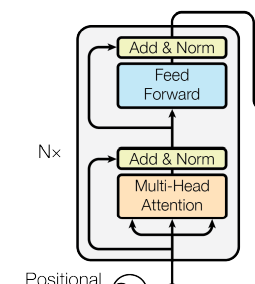

In [3]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        #word embedding을 수행하는 layer
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        #positional encoding을 수행하는 layer
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

# Multi-Head Attention
Multi-Head Attention은 Query, Key, Value(각각 이하  q, k, v)를 이용하면서도 Scaled Dot Product Attention을 응용해 작동합니다. q, k, v에 대해 좀 더 구체적으로 설명하자면, q는 물어보는 주체,k는 물어보는 대상입니다. 예를 들어, I am a student라는 문장이 있다고 가정할때, self attention을 수행하면 각각의 단어가 다른 단어와 얼마나 연관성을 가지는지 판단하게 되는데 "I"라는 단어를 기준으로 self attention을 수행하는 단계에서는 "I"가 query가 되는 것이고(조금 더 정확하게 말하면 I라는 단어를 번역했을 때 무엇이 되는가?를 물어보는 것이겠지요), [I, am, a, student]이 단어 모두가 key가 되는 것입니다. 각 query 대해서 key에 대해 가중치를 구하기 위해서 attention score를 계산하고, 그 가중치를 value에 곱하는 방식입니다.

# 1. Scaled Dot-Product Attention

 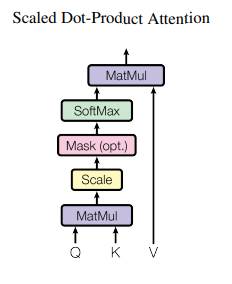

 위의 사진에서 보이는 바와 같이, 이 attention을 수행하는 구조체의 입력은 q, k, v입니다. 논문의 설명에 따르면, q와 k는 $d_k$의 차원이고, v는 $d_v$의 차원을 가집니다. 우선, 이 attention은 아래와 같은 공식으로 수행됩니다.

 $Attention(Q, K, V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$

 여기서, softmax함수를 통과한 값은 가중치가 되며, 이 가중치를 v에 dot-product하면서 v에 대한 가중합을 구해 output을 도출합니다. 가중치(softmax의 리턴값)는 q와 v가 유사할수록 더 높은 값을 가지게 되고 유사하지 않을수록 낮은 값을 가지게 됩니다.

 굳이 dot-product 기반의 attention을 도입한 이유는 계산이 빠르다는 것에 기인합니다. 논문에 따르면, 가장 흔하게 사용되는 attention은 addictive attention과 dot-product attention인데, 두 attention의 계산 복잡도는 비슷하지만 dot-product의 경우 행렬곱을 수행하는 코드가 최적화되어있어 계산 속도가 빠름과 동시에 공간복잡도 또한 상대적으로 우위에 있습니다.

 일반적인 dot-product attention과 다른 점이 있다면, $\sqrt{d_k}$로 나누어줬다는 것인데, 그 이유는 softmax함수의 특성에 있습니다. softmax는 x의 절댓값이 커질수록 증가율(gradient)이 감소합니다. 즉, $d_k$가 커서 행렬곱의 결과가 큰 경우 gradient가 작아지게 됩니다. 이를 $\sqrt{d_k}$로 나눠줘 scaling을 함으로써 gradient가 작아지는 현상을 완화하는 것입니다.

# 2. Multi-Head Attention
  
  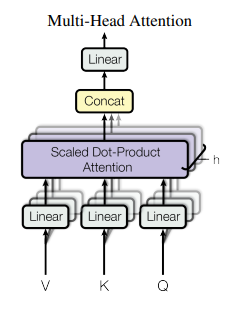
  
  논문은 k, v, q를 그대로 활용하지 않고 이를 선형적으로 project해 attention을 수행했을 때 더 좋은 성능을 보였다고 주장합니다. 각각의 v, k, q를 위 사진의 linear라는 layer에 통과시켰을 때 선형적으로 project되었다고 하는 것입니다. 이러한 projection을 h번 수행합니다. 그렇게 project된 v, k, q를 앞서 설명한 Scaled dot-project attention에 입력시켜 결과를 도출합니다. 이때, 각 v, k, q에 대해 i번째 attention 결과를 $head_i$라고 표현합니다.

  $head_i=Attention(QW_{i}^{Q},KW_{i}^{K},VW_{i}^{V})$

  attention을 수행하는 layer를 attention layer라고 할 때, attention layer에는 Scaled dot-product attention을 수행하는 노드가 h개가 있습니다. 이는 h번 project를 했다는 것에 기인합니다. 여기서 추론할 수 있는 것은, i의 최댓값은 h라는 것입니다. 즉, head는 h개가 존재하는데, 이것들을 하나로 concat시키고 $W^O$에 곱해 결과를 도출시킵니다.

  여기서 $W$란, parameter matrics를 의미하며, 

  $W_{i}^{Q} \in R^{d_{model} \times d_k}$

  $W_{i}^{K} \in R^{d_{model} \times d_k}$

  $W_{i}^{V} \in R^{d_{model} \times d_V}$

  $W_{i}^{O} \in R^{hd_v \times d_{model}}$

  입니다.
  
  $output=MultiHead(Q, K, V)=Concat(head_1,...,head_h)W^O$

# 3. $W$들은 무엇을 의미하는가? 왜 linear layer를 통과하면 project되는가?
    
갑자기 2번의 설명에서 $W$가 등장했습니다. 여기서 $W$란 linear layer의 가중치들을 의미합니다. 각 가중치를 행렬로 표현한 것이 $W$입니다. i번째 q, k, v에 대한 $W$가 각각 $W_{i}^{Q}, W_{i}^{K}, W_{i}^{V}$ 입니다.

linear layer를 통과시키면 project되는 이유는 다음 예시를 통해 설명드리겠습니다.

student에 대해 워드 임베딩 벡터가 1$\times$5벡터라고 합시다. 이를 5$\times$2 행렬인 $W_{student}^{Q}$에 통과시키게 되면 이 연산에 대한 결과는 1$\times$2벡터가 됩니다. 즉, 5차원을 2차원 벡터로 표현하게 되는 것입니다.



In [4]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        #query에 대한 fully connected layer
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        #key에 대한 fully connected layer
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        #value에 대한 fully connected layer
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        #output에 대한 fully connected layer
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

# Position-wise Feed-Forward

앞서 encoder설명에서 언급한 position wise입니다. position wise layer는 encoder에만 존재하는게 아니라, decoder에도 존재합니다. 우선, position wise network는 fully connected된 신경망이며 activation fuction으로 ReLu함수를 사용합니다.

단순히 ReLu함수를 통과한 것을 output으로 도출하는 것이 아니라, 이를 linear layer에 한번 더 통과시킵니다. 즉, 아래의 공식과 같이 정의할 수 있습니다.

$PositionWise(x)=max(0,xW_1+b_1)W_2+b_2$

$W_1, b_1$은 각각 첫번째 fully connected layer의 가중치, bias

$W_2, b_2$은 각각 두번째 fully connected layer의 가중치, bias

여기서 max함수가 적용되는 이유는 ReLu함수를 사용한다는 데에 기인합니다. ReLu함수는 $input<=0$인 구간에서는 0을 리턴하고, 이외의 구간에서는 input을 그대로 리턴합니다. 즉, max함수에 들어가는 $xW_1+b_1$은 첫번째 신경망의 연산 결과고 이에 max함수를 취해주는 것은 ReLu함수를 적용시키는 것을 표현하는 것입니다.

결국 max함수와 $W_2$를 곱해 $b_2$를 더해주는 것은 linear layer에 통과시키는 것을 표현하는 것입니다.




# 왜 position wise인가?
- 개별 단어마다(position마다) 적용되기 때문입니다.


In [5]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        # fully connected layer 정의
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        # relu를 사용하는 첫번째 fully connected layer
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        # relu가 씌워진 결과를 linear layer에 넣기
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

# Decoder

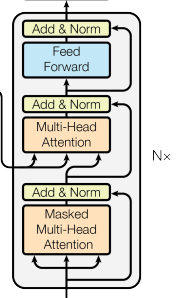

위의 사진에서 보이는 바와 같이 decoder는 전반적으로 encoder와 작동 방식이 비슷합니다. 차이점으로, 첫번째 sub-layer에서 masking을 수행한다는 것, 두번째 sub-layer에서 attention을 수행하기 위해 첫번째 sub-layer의 결과와 encoder연산의 결과를 input으로 받는다는 것입니다.

masking을 수행한다는 것은 특정 단어에 대해 self attention을 수행할 때 자신의 앞에 등장하는 단어만 검토하고, 뒤에 나오는 단어는 검토하지 않는다는 것을 의미합니다. 이를 수학적으로 설명하자면, attention 수식인
$Attention(Q, K, V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$에서 현재 단어 뒤에 있는 모든 단어들에 대해 softmax함수의 input을 $\frac{QK^T}{\sqrt{d_k}}$대신에 $-∞$로 설정하는 것입니다. 그렇게 되면 항상 작은 값을 리턴하게 되어 뒤에 있는 단어에 대해 attention을 주는 것을 막게됩니다.

decoder의 output은 query에 대한 대답입니다. "I am a student"를 "나는 학생입니다"로 번역해야 할 때, source sentence는 "I am a student"가 되고 target sentence는 "나는 학생입니다"가 되는데, "I am a student"가 한국어로 무엇인가?라고 물어본 것에 대한 대답이 "나는 학생입니다"라면, 당연히 decoder에서는 query에 대한 대답을 리턴해야 할 것입니다.

In [6]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        # word embedding
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        # positional encoding
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

# Transformer모델 정의

In [7]:
class transformer(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

# 각각 순서대로
- input dimension = source sentence들에서 등장한 단어의 개수
- output dimension = target sentence들에서 등장한 단어의 개수
- hidden_dim(하나의 단어에 대한 임베딩 차원) = 256
- 3개의 인코더
- 3개의 디코더
- 인코더, 디코더의 scaled dot-product attention의 개수 = 8
- 인코더, 디코더에서 feedforward레이어의 내부 임베딩 차원 = 512
- 각각 dropout비율=0.1

In [8]:
####순서는 이 영역의 순서임######
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS, DEC_HEADS = 8, 8
ENC_PF_DIM, DEC_PF_DIM = 512, 512
ENC_DROPOUT, DEC_DROPOUT = 0.1, 0.1
################################

# 정의한 파라미터를 이용해 인코더와 디코더 정의
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [9]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,037,572 trainable parameters


# 가중치 초기화

In [11]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [12]:
model.apply(initialize_weights);

# 학습률=0.005로 정의 및 Adam 경사하강법 진행

In [13]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Loss: CrossEntropy

In [14]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# 학습을 수행하는 함수, loss계산함수 정의. 추가적으로, 학습 시간을 계산하는 함수 정의 

In [15]:
def train(model, iterator, optimizer, criterion, clip): #학습 함수
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion): #loss계산함수
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time): #학습 시간 계산함수
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#학습 횟수: 10번

In [16]:

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 19s
	Train Loss: 4.232 | Train PPL:  68.831
	 Val. Loss: 3.040 |  Val. PPL:  20.904
Epoch: 02 | Time: 0m 18s
	Train Loss: 2.819 | Train PPL:  16.755
	 Val. Loss: 2.302 |  Val. PPL:   9.995
Epoch: 03 | Time: 0m 17s
	Train Loss: 2.237 | Train PPL:   9.368
	 Val. Loss: 1.976 |  Val. PPL:   7.215
Epoch: 04 | Time: 0m 17s
	Train Loss: 1.885 | Train PPL:   6.584
	 Val. Loss: 1.804 |  Val. PPL:   6.076
Epoch: 05 | Time: 0m 18s
	Train Loss: 1.637 | Train PPL:   5.141
	 Val. Loss: 1.716 |  Val. PPL:   5.561
Epoch: 06 | Time: 0m 17s
	Train Loss: 1.450 | Train PPL:   4.264
	 Val. Loss: 1.651 |  Val. PPL:   5.214
Epoch: 07 | Time: 0m 18s
	Train Loss: 1.298 | Train PPL:   3.661
	 Val. Loss: 1.625 |  Val. PPL:   5.081
Epoch: 08 | Time: 0m 18s
	Train Loss: 1.170 | Train PPL:   3.224
	 Val. Loss: 1.618 |  Val. PPL:   5.041
Epoch: 09 | Time: 0m 18s
	Train Loss: 1.061 | Train PPL:   2.890
	 Val. Loss: 1.631 |  Val. PPL:   5.109
Epoch: 10 | Time: 0m 18s
	Train Loss: 0.965 | Train PPL

# 전반적인 성능 확인

In [17]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.671 | Test PPL:   5.317 |


# 학습이 끝났으니, 문장을 입력받아 번역하는 함수 정의

In [18]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

# attention이 잘 이루어졌는지 확인(과제에서 요구한 부분은 아님)

In [19]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['']+[t.lower() for t in sentence]+[''], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

# 8개의 문장에 대해 실험해봄

In [20]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


# 결과로 나온 문장
"A woman with a large purse walks by a gate."

In [21]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '']


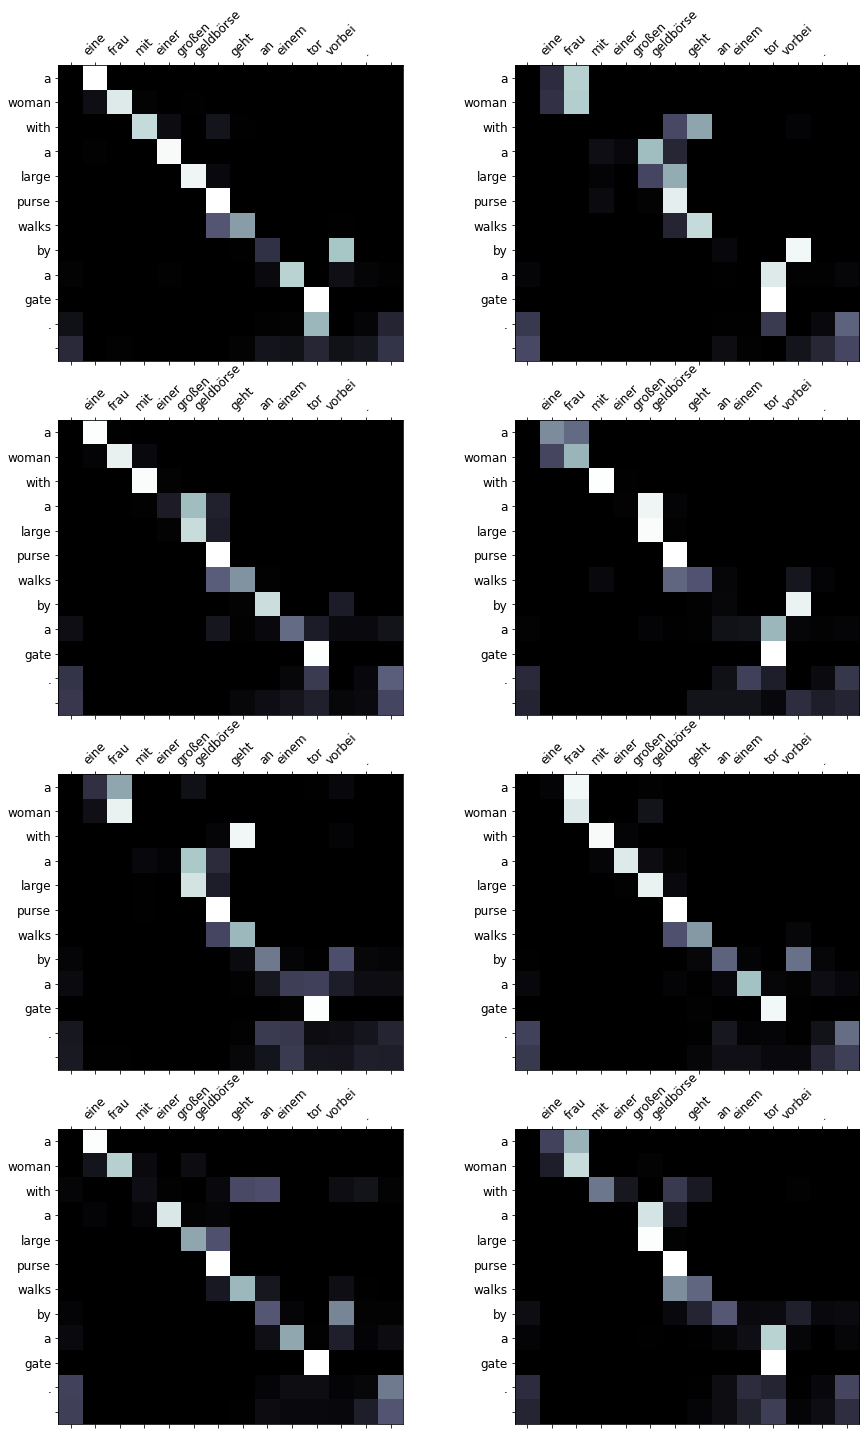

In [22]:
display_attention(src, translation, attention)

# Belu_score(과제에서 요구한 부분은 아님)

In [23]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off  token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')


BLEU score = 35.73
